In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
import torch
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import neural_network_lyapunov
import neural_network_lyapunov.relu_system as relu_system
import neural_network_lyapunov.lyapunov as lyapunov
import neural_network_lyapunov.encoders as encoders
import neural_network_lyapunov.pybullet_data_generation as pybullet_data_generation
import neural_network_lyapunov.dynamics_learning as dynamics_learning

## Load settings and models

In [21]:
folder = "pendulum_1007"

sys.path.insert(0, os.path.join(os.path.dirname(neural_network_lyapunov.__file__), "..", "notebooks", folder))
import options
opt = dynamics_learning.DynamicsLearningOptions(options.default)

In [4]:
x_data = torch.load(os.path.join(folder, "x_data"))
x_next_data = torch.load(os.path.join(folder, "x_next_data"))
X_data = torch.load(os.path.join(folder, "X_data"))
X_next_data = torch.load(os.path.join(folder, "X_next_data"))
X_rollouts = torch.load(os.path.join(folder, "X_rollouts"))
x_rollouts = torch.load(os.path.join(folder, "x_rollouts"))

In [5]:
x_data_ = dynamics_learning.add_noise(x_data, opt.pybullet_noise)
x_next_data_ = dynamics_learning.add_noise(x_next_data, opt.pybullet_noise)
x_train_dataloader, x_validation_dataloader = dynamics_learning.get_dataloaders(x_data_, x_next_data_, opt.batch_size, opt.validation_ratio)

X_train_dataloader, X_validation_dataloader = dynamics_learning.get_dataloaders(X_data, X_next_data, opt.batch_size, opt.validation_ratio)

In [6]:
learners = dict()
for variant in options.variants.keys():
    opt.set_options(options.variants[variant])
    
    dyn_nn_model = dynamics_learning.get_ff_network(opt.dtype, opt.z_dim, opt.z_dim, opt.dyn_nn_width, opt.dyn_nn_depth)
    lyap_nn_model = dynamics_learning.get_ff_network(opt.dtype, opt.z_dim, 1, opt.lyap_nn_width, opt.lyap_nn_depth)

    relu_sys = relu_system.AutonomousReLUSystem(opt.dtype, opt.z_lo, opt.z_up, dyn_nn_model)
    lyap = lyapunov.LyapunovDiscreteTimeHybridSystem(relu_sys, lyap_nn_model)
    encoder = opt.encoder_class(opt.z_dim, opt.image_width, opt.image_height, opt.grayscale)
    decoder = opt.decoder_class(opt.z_dim, opt.image_width, opt.image_height, opt.grayscale)

    dyn_learner = dynamics_learning.LatentSpaceDynamicsLearning(X_train_dataloader, X_validation_dataloader,
                                                                relu_sys, lyap, opt,
                                                                encoder, decoder,
                                                                use_bce=opt.use_bce,
                                                                use_variational=opt.use_variational)
    
    dyn_learner.relu_system.dynamics_relu = torch.load(os.path.join(folder, variant, "dynamics"))
    dyn_learner.lyapunov.lyapunov_relu = torch.load(os.path.join(folder, variant, "lyapunov"))
    dyn_learner.encoder = torch.load(os.path.join(folder, variant, "encoder"))
    dyn_learner.decoder = torch.load(os.path.join(folder, variant, "decoder"))
    
    learners[variant] = dyn_learner

## Comparing models

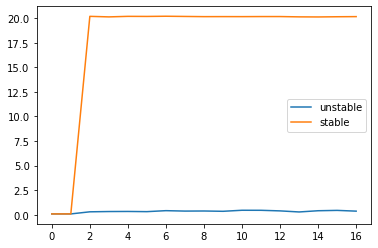

In [11]:
legend = []
for name in learners.keys():
    dyn_learner = learners[name]
    rollout_loss = dyn_learner.rollout_validation(X_rollouts, device='cuda')
    plt.plot(rollout_loss)
    legend.append(name)
plt.legend(legend)
plt.show()

In [23]:
z_adv_pos, z_adv_der = learners["stable"].adversarial_samples(optimal=opt.lyapunov_loss_optimal)

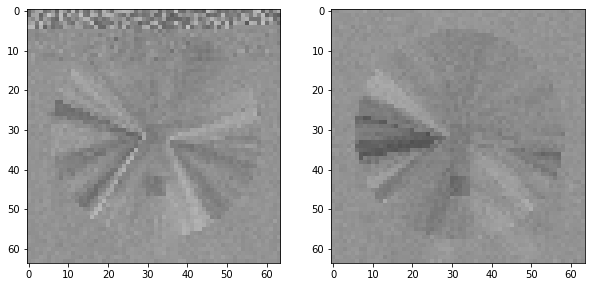

*****


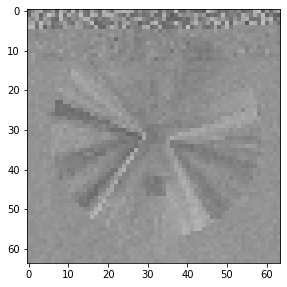

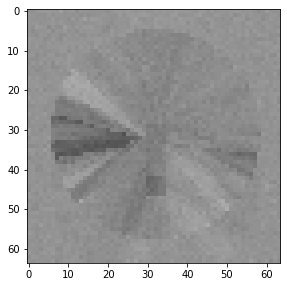

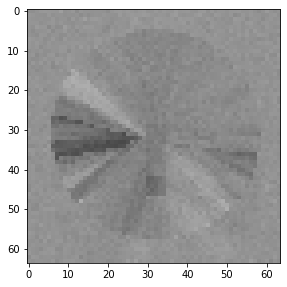

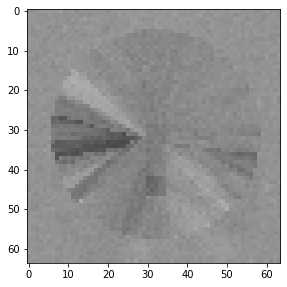

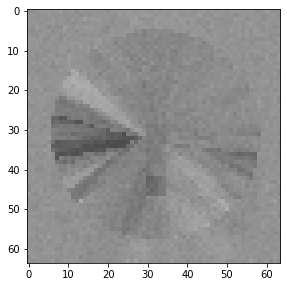

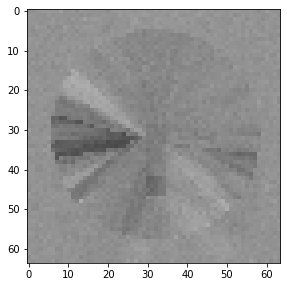

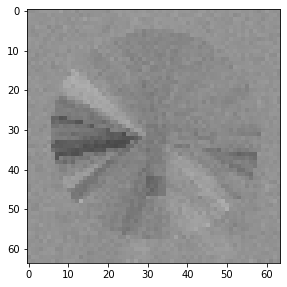

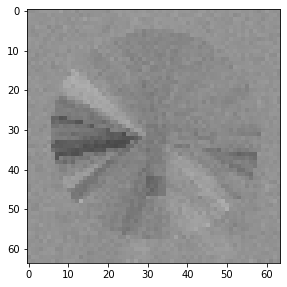

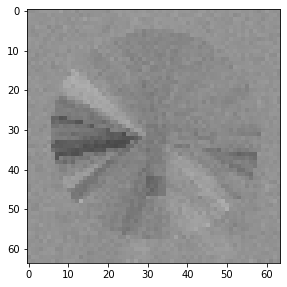

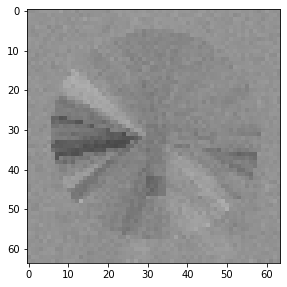

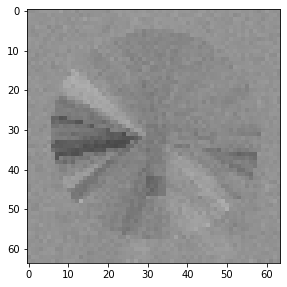

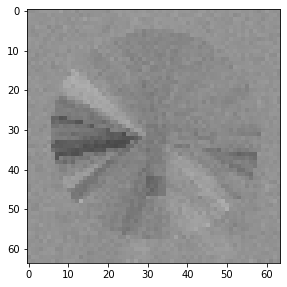

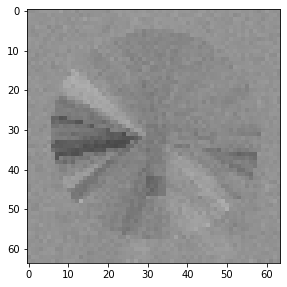

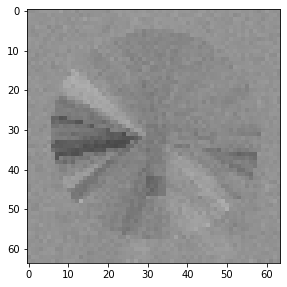

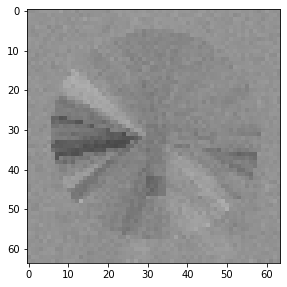

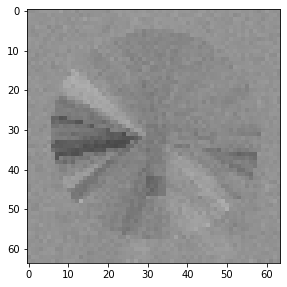

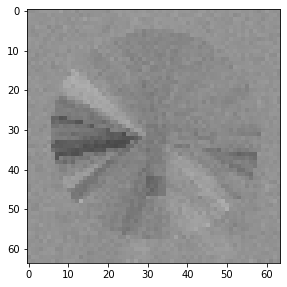

In [26]:
# rolling out the adversarial samples

# z_adv = z_adv_pos
z_adv = z_adv_der
i = np.random.choice(z_adv.shape[0], 1)[0]
X_adv = dyn_learner.decoder(z_adv[i, :].unsqueeze(0))[0, :]
pybullet_data_generation.show_sample(X_adv)

print("*****")

x_traj = dyn_learner.rollout(X_adv, opt.validation_rollouts_N)
for n in range(x_traj.shape[0]):
    pybullet_data_generation.show_sample(x_traj[n, :])